In [60]:
# 1.1

In [2]:
import torch
import torch.nn.functional as F
from typing import Tuple

In [3]:
import torch
import torch.nn.functional as F
from typing import Tuple


def gd_factorise_ad(
    A: torch.Tensor, rank: int, num_epochs=1000, lr=0.01
) -> Tuple[torch.Tensor, torch.Tensor]:
    m, n = A.shape

    U_hat = torch.rand(m, rank, requires_grad=True)
    V_hat = torch.rand(n, rank, requires_grad=True)

    for epoch in range(num_epochs):
        A_pred = torch.matmul(U_hat, V_hat.t())
        loss = F.mse_loss(A_pred, A, reduction="sum")
        loss.backward()
        with torch.no_grad():
            U_hat -= lr * U_hat.grad
            V_hat -= lr * V_hat.grad

            U_hat.grad.zero_()
            V_hat.grad.zero_()

    return U_hat, V_hat, A_pred

In [4]:
import torch


A = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])

rank = 4
U_hat, V_hat, A_predicted = gd_factorise_ad(A, rank)

print("Factorized matrix U_hat:")
print(U_hat)
print("\nFactorized matrix V_hat:")
print(V_hat)

print("\nPredicted matrix A:")
print(A_predicted)

Factorized matrix U_hat:
tensor([[0.8203, 0.2511, 0.5149, 1.0619],
        [1.0493, 1.7816, 1.8136, 0.7474]], requires_grad=True)

Factorized matrix V_hat:
tensor([[ 0.4113,  1.0787,  0.9447, -0.0891],
        [ 0.3292,  1.1911,  1.0511,  0.8378],
        [ 1.3996,  0.8200,  1.3175,  0.9113]], requires_grad=True)

Predicted matrix A:
tensor([[1.0000, 2.0000, 3.0000],
        [4.0000, 5.0000, 6.0000]], grad_fn=<MmBackward0>)


In [5]:
print("Shape of U_hat:", U_hat.shape)
print("Shape of V_hat:", V_hat.shape)

Shape of U_hat: torch.Size([2, 4])
Shape of V_hat: torch.Size([3, 4])


In [6]:
# 1.2

In [20]:
import torch
import pandas as pd

df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data",
    header=None,
)
data = torch.tensor(df.iloc[:, [0, 1, 2, 3]].values, dtype=torch.float32)
data = data - data.mean(dim=0)


rank = 2  # USING rank 4 gives low error
U_hat, V_hat, A_predicted = gd_factorise_ad(data, rank)

A_pred = torch.matmul(U_hat, V_hat.t())
reconstruction_loss_ad = torch.nn.functional.mse_loss(
    A_pred, data, reduction="sum"
).item()

U, S, V = torch.svd(data)
U_truncated = U[:, :rank]
S_truncated = torch.diag(S[:rank])
V_truncated = V[:, :rank]
A_pred_svd = torch.matmul(U_truncated, torch.matmul(S_truncated, V_truncated.t()))
reconstruction_loss_svd = torch.nn.functional.mse_loss(
    A_pred_svd, data, reduction="sum"
).item()

print("Reconstruction Loss using gd_factorise_ad:", reconstruction_loss_ad)
print("Reconstruction Loss using truncated SVD:", reconstruction_loss_svd)

/var/folders/9q/w7dg5r0s76sb6z8r8j3k4ll80000gn/T/ipykernel_23371/2045343545.py:16: UserWarning: Using a target size (torch.Size([150, 4])) that is different to the input size (torch.Size([4, 150])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  reconstruction_loss_ad = torch.nn.functional.mse_loss(


RuntimeError: The size of tensor a (150) must match the size of tensor b (4) at non-singleton dimension 1

In [8]:
A_predicted.type()

'torch.FloatTensor'

In [9]:
U, S, V = torch.svd(data)

In [10]:
data.size()

torch.Size([150, 4])

In [11]:
# 1.3

In [22]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
import numpy as np

# Load the Iris dataset
iris = load_iris()
data_np = iris.data  # Get the features; it's already a numpy array
data = torch.tensor(data_np, dtype=torch.float32)  # Convert to PyTorch tensor

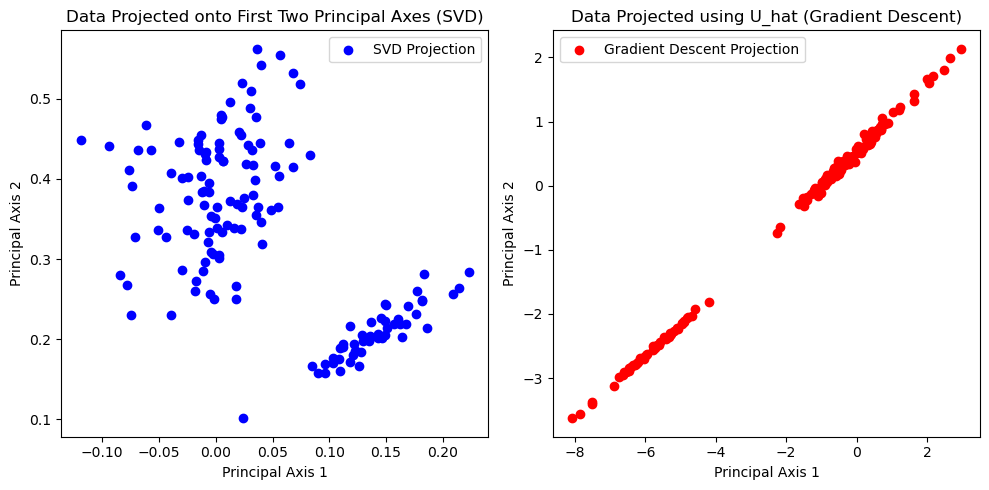

In [23]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
import numpy as np

# Load Iris dataset
iris = load_iris()
data_np = iris.data  # Only take features
data = torch.tensor(data_np, dtype=torch.float32)

# SVD Projection
U, S, V = torch.svd(data)
data_svd_projected = torch.matmul(data, U.t()[:, :2])

# Gradient Descent Factorization
rank = 4
U_hat, V_hat, A_predicted = gd_factorise_ad(data, rank)
data_gd_projected = torch.matmul(data, U_hat[:, :4].t())
data_gd_projected_np = data_gd_projected.detach().numpy()

# Visualization
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(
    data_svd_projected[:, 0], data_svd_projected[:, 1], c="blue", label="SVD Projection"
)
plt.title("Data Projected onto First Two Principal Axes (SVD)")
plt.xlabel("Principal Axis 1")
plt.ylabel("Principal Axis 2")
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(
    data_gd_projected_np[:, 0],
    data_gd_projected_np[:, 1],
    c="red",
    label="Gradient Descent Projection",
)
plt.title("Data Projected using U_hat (Gradient Descent)")
plt.xlabel("Principal Axis 1")
plt.ylabel("Principal Axis 2")
plt.legend()

plt.tight_layout()
plt.show()

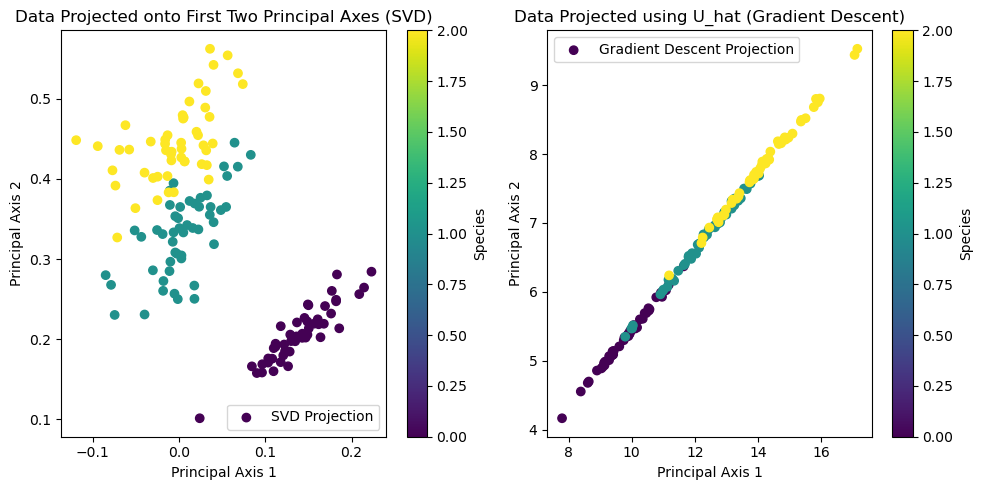

In [24]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
import numpy as np

# Load Iris dataset
iris = load_iris()
data_np = iris.data  # Only take features
data = torch.tensor(data_np, dtype=torch.float32)
targets = iris.target  # Species labels

# SVD Projection
U, S, V = torch.svd(data)
data_svd_projected = torch.matmul(data, U.t()[:, :2])

# Gradient Descent Factorization
rank = 4
U_hat, V_hat, A_predicted = gd_factorise_ad(data, rank)
data_gd_projected = torch.matmul(data, U_hat[:, :4].t())
data_gd_projected_np = data_gd_projected.detach().numpy()

# Visualization
plt.figure(figsize=(10, 5))

# Scatter plot for SVD Projection
plt.subplot(1, 2, 1)
scatter = plt.scatter(
    data_svd_projected[:, 0],
    data_svd_projected[:, 1],
    c=targets,
    cmap="viridis",
    label="SVD Projection",
)
plt.title("Data Projected onto First Two Principal Axes (SVD)")
plt.xlabel("Principal Axis 1")
plt.ylabel("Principal Axis 2")
plt.legend()
plt.colorbar(scatter, label="Species")

# Scatter plot for Gradient Descent Projection
plt.subplot(1, 2, 2)
scatter = plt.scatter(
    data_gd_projected_np[:, 0],
    data_gd_projected_np[:, 1],
    c=targets,
    cmap="viridis",
    label="Gradient Descent Projection",
)
plt.title("Data Projected using U_hat (Gradient Descent)")
plt.xlabel("Principal Axis 1")
plt.ylabel("Principal Axis 2")
plt.legend()
plt.colorbar(scatter, label="Species")

plt.tight_layout()
plt.show()

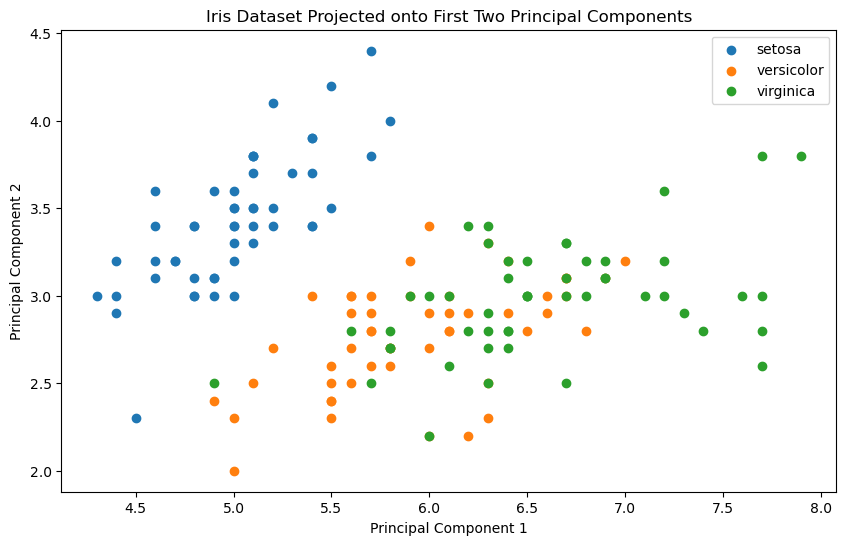

In [25]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
import numpy as np

# Load the Iris dataset
iris = load_iris()
data = iris.data
target = iris.target
target_names = iris.target_names

# Assume `data_projected` is your 2D projection of the Iris dataset, e.g., using PCA
# For demonstration, let's pretend we've already projected it to two principal components
# This step would typically involve PCA, but here we'll just slice original features for simplicity
data_projected = data[:, :2]

# Create a new figure with a specific size
plt.figure(figsize=(10, 6))

# Create a scatter plot
for target_id, target_name in enumerate(target_names):
    plt.scatter(
        data_projected[target == target_id, 0],
        data_projected[target == target_id, 1],
        label=target_name,
    )

# Adding titles and labels
plt.title("Iris Dataset Projected onto First Two Principal Components")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# Adding a legend to explain which colors correspond to which species
plt.legend()

# Show the plot
plt.show()

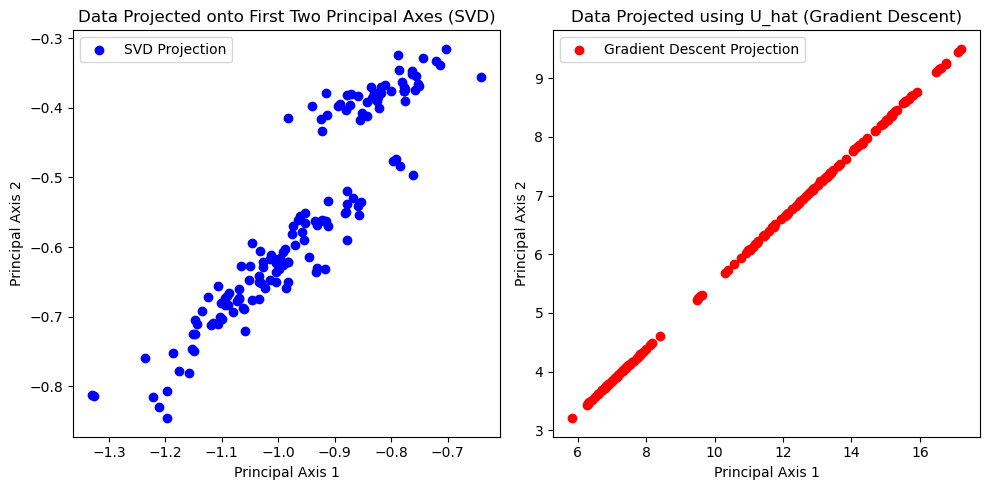

In [13]:
import matplotlib.pyplot as plt

U, S, V = torch.svd(data)


data_svd_projected = torch.matmul(data, U.t()[:, :2])
rank = 4
U_hat, V_hat, A_predicted = gd_factorise_ad(data, rank)

data_gd_projected = torch.matmul(data, U_hat[:, :4].t())
data_gd_projected_np = data_gd_projected.detach().numpy()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(
    data_svd_projected[:, 0], data_svd_projected[:, 1], c="blue", label="SVD Projection"
)
plt.title("Data Projected onto First Two Principal Axes (SVD)")
plt.xlabel("Principal Axis 1")
plt.ylabel("Principal Axis 2")
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(
    data_gd_projected_np[:, 0],
    data_gd_projected_np[:, 1],
    c="red",
    label="Gradient Descent Projection",
)

plt.title("Data Projected using U_hat (Gradient Descent)")
plt.xlabel("Principal Axis 1")
plt.ylabel("Principal Axis 2")
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
import torch
import matplotlib.pyplot as plt

# Let's assume 'data' is your feature tensor and 'targets' contains the corresponding labels
# Performing SVD
U, S, V = torch.svd(data)
data_svd_projected = torch.matmul(data, U.t()[:, :2])

# Performing gradient descent factorisation (assuming you have a function `gd_factorise_ad` defined)
rank = 4
U_hat, V_hat, A_predicted = gd_factorise_ad(data, rank)
data_gd_projected = torch.matmul(data, U_hat[:, :4].t())
data_gd_projected_np = data_gd_projected.detach().numpy()

# Colors for the Iris dataset classes
colors = ["blue", "green", "red"]  # Assign colors for each class
target_colors = [colors[label] for label in targets]  # Map labels to colors

plt.figure(figsize=(10, 5))

# SVD Projection plot
plt.subplot(1, 2, 1)
plt.scatter(
    data_svd_projected[:, 0],
    data_svd_projected[:, 1],
    c=target_colors,
    label="SVD Projection",
)
plt.title("Data Projected onto First Two Principal Axes (SVD)")
plt.xlabel("Principal Axis 1")
plt.ylabel("Principal Axis 2")
plt.legend()

# Gradient Descent Projection plot
plt.subplot(1, 2, 2)
plt.scatter(
    data_gd_projected_np[:, 0],
    data_gd_projected_np[:, 1],
    c=target_colors,
    label="Gradient Descent Projection",
)
plt.title("Data Projected using U_hat (Gradient Descent)")
plt.xlabel("Principal Axis 1")
plt.ylabel("Principal Axis 2")
plt.legend()

plt.tight_layout()
plt.show()

NameError: name 'targets' is not defined

In [15]:
print(U_hat.shape)

torch.Size([4, 4])


In [68]:
print("Shape of U_hat:", U_hat.shape)
print("Data", data.shape)

Shape of U_hat: torch.Size([2, 4])
Data torch.Size([150, 4])


In [69]:
print("Shape of data_gd_projected:", data_gd_projected.shape)
print("data_gd_projected:", data_gd_projected)

Shape of data_gd_projected: torch.Size([150, 150])
data_gd_projected: tensor([[ 1.7475,  1.9180,  1.5875,  ..., -1.4518, -2.7747, -1.5895],
        [ 1.9365,  2.2122,  1.9366,  ..., -1.6621, -2.9058, -1.5786],
        [ 2.0711,  2.2423,  1.9911,  ..., -1.7338, -2.9624, -1.6377],
        ...,
        [-1.3236, -1.4755, -1.2912,  ...,  1.0550,  1.8628,  1.0966],
        [-1.4130, -1.8569, -1.5430,  ...,  1.1893,  2.3095,  1.3268],
        [-0.8069, -1.0741, -0.8075,  ...,  0.7425,  1.6305,  0.8934]],
       dtype=torch.float32, grad_fn=<MmBackward0>)


In [70]:
# 2.1

In [88]:
import torch
import torch.nn.functional as F
import pandas as pd

df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data",
    header=None,
)
df = df.sample(frac=1)  # shuffle

mapping = {k: v for v, k in enumerate(df[4].unique())}
df[5] = df[4].map(mapping)

alldata = torch.tensor(df.iloc[:, [0, 1, 2, 3]].values, dtype=torch.float)
alldata = (alldata - alldata.mean(dim=0)) / alldata.var(dim=0)
targets_tr = torch.tensor(df.iloc[:100, 5].values, dtype=torch.long)
targets_va = torch.tensor(df.iloc[100:, 5].values, dtype=torch.long)
data_tr = alldata[:100]
data_va = alldata[100:]

torch.manual_seed(0)  # for reproducibility
W1 = torch.randn(4, 12, requires_grad=True)
b1 = torch.zeros(12, requires_grad=True)
W2 = torch.randn(12, 3, requires_grad=True)
b2 = torch.zeros(3, requires_grad=True)


num_epochs = 100
lr = 0.01


for epoch in range(num_epochs):
    logits = torch.relu(data_tr.double() @ W1 + b1) @ W2 + b2
    loss = F.cross_entropy(logits, targets_tr)

    loss.backward()

    with torch.no_grad():
        W1 -= lr * W1.grad
        b1 -= lr * b1.grad
        W2 -= lr * W2.grad
        b2 -= lr * b2.grad

        W1.grad.zero_()
        b1.grad.zero_()
        W2.grad.zero_()
        b2.grad.zero_()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}")

Epoch [10/100], Loss: 2.011843601968621
Epoch [20/100], Loss: 1.5004752394258976
Epoch [30/100], Loss: 1.2800464865147183
Epoch [40/100], Loss: 1.1422201416981963
Epoch [50/100], Loss: 1.0355315779718806
Epoch [60/100], Loss: 0.9481721427374639
Epoch [70/100], Loss: 0.8733309665035519
Epoch [80/100], Loss: 0.8093400860716824
Epoch [90/100], Loss: 0.7535042406265913
Epoch [100/100], Loss: 0.7017723801635813


In [86]:
# 2.2

data_tr.type()

W2.type()

'torch.DoubleTensor'

In [102]:
import pandas as pd


def train_mlp(
    num_epochs=100, lr=0.1
):  # CHANGE LEARNING RATE TO 0.1 to see and increase in ACCURACY OF  TRAINIG AND VALIDATION

    torch.manual_seed(0)  # for reproducibility
    W1 = torch.randn(4, 12, requires_grad=True)
    b1 = torch.zeros(12, requires_grad=True)
    W2 = torch.randn(12, 3, requires_grad=True)
    b2 = torch.zeros(3, requires_grad=True)

    for epoch in range(num_epochs):

        logits = torch.relu(data_tr.double() @ W1 + b1) @ W2 + b2
        loss = F.cross_entropy(logits, targets_tr)
        loss.backward()

        with torch.no_grad():
            W1 -= lr * W1.grad
            b1 -= lr * b1.grad
            W2 -= lr * W2.grad
            b2 -= lr * b2.grad

            W1.grad.zero_()
            b1.grad.zero_()
            W2.grad.zero_()
            b2.grad.zero_()

    with torch.no_grad():
        logits_tr = torch.relu(data_tr.double() @ W1 + b1) @ W2 + b2
        pred_tr = torch.argmax(logits_tr, dim=1)
        accuracy_tr = (pred_tr == targets_tr).float().mean().item()

        logits_va = torch.relu(data_va.double() @ W1 + b1) @ W2 + b2
        pred_va = torch.argmax(logits_va, dim=1)
        accuracy_va = (pred_va == targets_va).float().mean().item()

    return accuracy_tr, accuracy_va


# Run MLP and compute accuracies
num_runs = 9
for i in range(num_runs):
    accuracy_tr, accuracy_va = train_mlp()
    print(
        f"Run {i + 1}: Training Accuracy: {accuracy_tr}, Validation Accuracy: {accuracy_va}"
    )

Run 1: Training Accuracy: 0.9800000190734863, Validation Accuracy: 0.8600000143051147
Run 2: Training Accuracy: 0.9800000190734863, Validation Accuracy: 0.8600000143051147
Run 3: Training Accuracy: 0.9800000190734863, Validation Accuracy: 0.8600000143051147
Run 4: Training Accuracy: 0.9800000190734863, Validation Accuracy: 0.8600000143051147
Run 5: Training Accuracy: 0.9800000190734863, Validation Accuracy: 0.8600000143051147
Run 6: Training Accuracy: 0.9800000190734863, Validation Accuracy: 0.8600000143051147
Run 7: Training Accuracy: 0.9800000190734863, Validation Accuracy: 0.8600000143051147
Run 8: Training Accuracy: 0.9800000190734863, Validation Accuracy: 0.8600000143051147
Run 9: Training Accuracy: 0.9800000190734863, Validation Accuracy: 0.8600000143051147


Error of A_sgd:  tensor(15.2297) 

Error of A:  tensor(15.2288) 



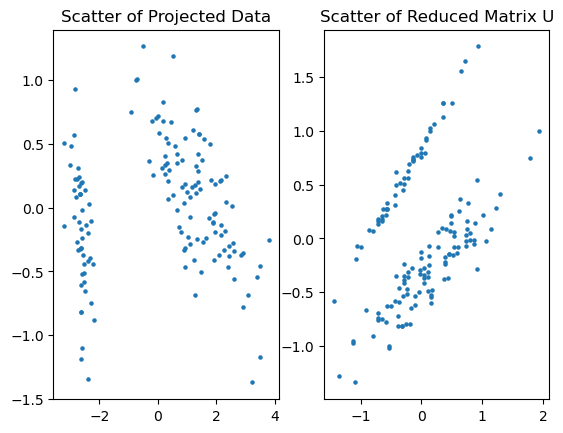

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


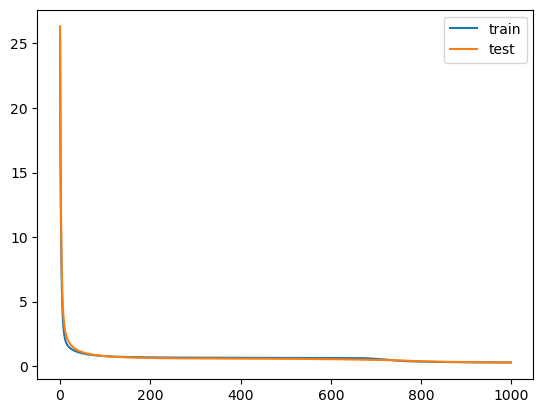

tensor([ 1.3607,  0.7500,  1.3607,  1.3607,  1.3607,  1.3607,  1.3607,  1.3607,
         1.3607,  1.3607,  1.3607,  1.3607,  1.3607,  0.1019, -0.7803,  1.3607,
         0.8224,  1.3607,  1.3607,  1.3607,  1.3607, -0.4645,  1.3607,  0.2046,
         1.3607,  1.3607,  0.1785,  1.3607,  1.3607, -0.5720,  1.0027, -0.1437,
         1.1242,  1.3607,  1.3607,  1.3607,  1.3607,  1.3607,  1.3607,  1.3607,
         1.3607, -0.9256,  1.3607,  1.3607,  0.3553,  1.3607, -0.1538, -0.3906,
         1.3607,  1.3607]) 
 tensor([2., 0., 2., 2., 1., 2., 1., 1., 1., 1., 1., 1., 2., 0., 0., 2., 0., 1.,
        1., 1., 2., 0., 1., 0., 1., 2., 0., 1., 2., 0., 2., 0., 2., 2., 2., 1.,
        2., 1., 1., 2., 2., 0., 1., 2., 0., 2., 0., 0., 1., 1.]) 

tensor(0.2885) 

tensor([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,
        -1.,  1.,  1.,  1.,  1.,  1.,  1., -0.,  1.,  0.,  1.,  1.,  0.,  1.,
         1., -1.,  1., -0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,
         1., 

In [72]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple


torch.set_default_dtype(torch.float64)


# Q1.1
def gd_factorise_ad(
    A_: torch.Tensor, rank: int, num_epochs=1000, lr=0.01
) -> Tuple[torch.Tensor, torch.Tensor]:
    m, n = A_.shape
    U_ = torch.rand(m, rank, requires_grad=True)
    V_ = torch.rand(n, rank, requires_grad=True)
    for epoch in range(num_epochs):
        A_sgd = U_ @ V_.t()
        loss = torch.nn.functional.mse_loss(A_sgd, A_, reduction="sum")
        loss.backward(torch.ones(loss.shape))
        with torch.no_grad():
            U_ -= lr * U_.grad
            V_ -= lr * V_.grad
        U_.grad.zero_()
        V_.grad.zero_()
        """E = A_ - U_ @ V_.t()
        U_ += lr * E @ V_
        V_ += lr * E.t() @ U_"""
    return U_.detach(), V_.detach()


# Q1.2
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases" + "/iris/iris.data",
    header=None,
)
data = torch.tensor(df.iloc[:, [0, 1, 2, 3]].values)
data = data - data.mean(dim=0)

U_sgd, V_sgd = gd_factorise_ad(data, 2)
A_sgd = U_sgd @ V_sgd.t()
print(
    "Error of A_sgd: ", torch.nn.functional.mse_loss(A_sgd, data, reduction="sum"), "\n"
)

U, S, V = torch.svd(data)
S[2:] = 0.0
S = torch.diag(S)
A = U @ S @ V.t()
print("Error of A: ", torch.nn.functional.mse_loss(A, data, reduction="sum"), "\n")

# Q1.3
project = V[:, :2]
data_pca = data @ project
plt.subplot(1, 2, 1)
plt.scatter(data_pca[:, 0], data_pca[:, 1], s=5)
plt.title("Scatter of Projected Data")
plt.subplot(1, 2, 2)
plt.scatter(U_sgd[:, 0], U_sgd[:, 1], s=5)
plt.title("Scatter of Reduced Matrix U")
plt.savefig("pic.eps")
plt.show()

# Q2.1
df = df.sample(frac=1)
mapping = {k: v for v, k in enumerate(df[4].unique())}
df[5] = df[4].map(mapping)
alldata = torch.tensor(df.iloc[:, [0, 1, 2, 3]].values)
alldata = (alldata - alldata.mean(dim=0)) / alldata.var(dim=0)
targets_tr = torch.tensor(df.iloc[:100, 5].values, dtype=torch.double)
targets_va = torch.tensor(df.iloc[100:, 5].values, dtype=torch.double)
data_tr = alldata[:100]
data_va = alldata[100:]
N, features = data_tr.shape

W1 = torch.randn(features)
W2 = torch.randn(1)
b1 = b2 = 0
alpha = 0.0001


def model(X):
    return torch.relu(X @ W1 + b1) * W2 + b2


epochs = 1000
errors_tr = np.zeros(epochs)
errors_va = np.zeros(epochs)
for epoch in range(epochs):
    errors_tr[epoch] = torch.nn.functional.mse_loss(model(data_tr), targets_tr)
    errors_va[epoch] = torch.nn.functional.mse_loss(model(data_va), targets_va)
    for n in range(N):
        grad_b2 = model(data_tr[n]) - targets_tr[n]
        relu = torch.relu(data_tr[n] @ W1 + b1)
        b2 -= alpha * grad_b2
        W2 -= alpha * relu * grad_b2
        if not (relu == 0).all():
            b1 -= alpha * W2 * grad_b2
            W1 -= alpha * W2 * grad_b2 * data_tr[n]
plt.plot(np.arange(epochs), errors_tr)
plt.plot(np.arange(epochs), errors_va)
plt.legend(labels=["train", "test"])
plt.savefig("2.2.3.eps")
plt.show()
print(model(data_va), "\n", targets_va, "\n")
print(torch.nn.functional.mse_loss(model(data_va), targets_va), "\n")

predicts = model(data_va)
predicts = torch.round(predicts)
print(predicts)
bingo = 0
for i in range(len(predicts)):
    if predicts[i] == targets_va[i]:
        bingo += 1
print(bingo / targets_va.shape[0])

predicts = model(data_tr)
predicts = torch.round(predicts)
print(predicts)
bingo = 0
for i in range(len(predicts)):
    if predicts[i] == targets_tr[i]:
        bingo += 1
print(bingo / targets_tr.shape[0])